The codes in this notebook were tested on Google Colab with CPU.  

## 0. Setup Kaggle data

In [85]:
# Refer to https://www.youtube.com/watch?v=57N1g8k2Hwc for setup
# Install kaggle
!pip install -q kaggle

In [ ]:
# upload API json file (CAUTION! sensitive data)
from google.colab import files
files.upload()

In [ ]:
# for download
#result.to_csv('example_file.csv')
#!cp example_file.csv "/content/drive/My Drive/"

In [87]:
# create the kaggle folder and cp json file into it
!mkdir -p ~/.kaggle
!mv *json ~/.kaggle
!ls ~/.kaggle

kaggle.json


In [88]:
# change file permission
!chmod 600 ~/.kaggle/*json

In [89]:
# download HM dataset
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations

100% 28.7G/28.7G [03:11<00:00, 191MB/s]
100% 28.7G/28.7G [03:11<00:00, 161MB/s]


In [90]:
!mkdir -p hm_data

In [91]:
# extract only csv files
!unzip -p h-and-m-personalized-fashion-recommendations customers.csv > ./hm_data/customers.csv
!unzip -p h-and-m-personalized-fashion-recommendations articles.csv > ./hm_data/articles.csv
!unzip -p h-and-m-personalized-fashion-recommendations transactions_train.csv > ./hm_data/transactions_train.csv

In [92]:
!rm *zip

In [ ]:
# extract all files (large)
#!unzip *zip -d hm_data

In [ ]:
# remove kaggle API credentials
# !rm ~/.kaggle/*json

In [93]:
!ls hm_data

articles.csv  customers.csv  transactions_train.csv


In [94]:
!ls

gdrive	hm_data  sample_data


## 1. EDA

In [101]:
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm



In [102]:
mydir = "./hm_data"
articles = pd.read_csv(mydir+"/articles.csv")
customers = pd.read_csv(mydir+"/customers.csv")
transactions = pd.read_csv(mydir+"/transactions_train.csv")

In [ ]:
print(transactions.columns)
(n_cid_total, n_aid_total) = (customers.shape[0],articles.shape[0])
print(n_cid_total, n_aid_total)

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')
1371980 105542


### How many customers have purchase history?  1362281 / 1371980

In [ ]:
cid_buy = set(transactions['customer_id'])
print(len(cid_buy))
print(len(cid_buy)/n_cid_total)

1362281
0.9929306549658158


### How many items have buying customers? 104547 / 105542

In [ ]:
aid_buy =  set(transactions['article_id'])
len(aid_buy)
print(len(aid_buy)/n_aid_total)

0.9905724735176518


### Number of items bought per customer? Median 9

In [ ]:
transactions_byid_n = transactions.groupby('customer_id').count()

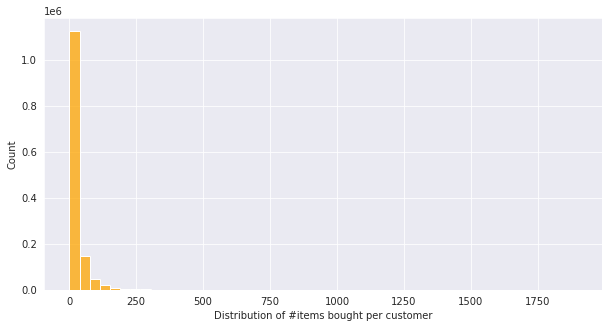

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=transactions_byid_n, x='t_dat', bins=50, color='orange')
ax.set_xlabel('Distribution of #items bought per customer')
plt.show()

In [ ]:
transactions_byid_n.t_dat.median()

9.0

### Purchase frequency？Median 8.5 days per item

In [ ]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'], format='%Y-%m-%d')

In [ ]:
transactions_byid = transactions.groupby('customer_id')

In [ ]:
transactions_byid2 = transactions_byid.agg(Minimum_Date=('t_dat', np.min), Maximum_Date=('t_dat', np.max), N_purchases=('t_dat', len))
 

In [ ]:
diff = (transactions_byid2['Maximum_Date']-transactions_byid2['Minimum_Date'])
diff_days = [d.days for d in diff]

In [ ]:
transactions_byid2['Days_per_Purchase'] = diff_days/transactions_byid2['N_purchases']

In [ ]:
transactions_byid2.head()

,Minimum_Date,Maximum_Date,N_purchases,Days_per_Purchase
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,2018-12-27,2020-09-05,21,29.428571
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,2018-09-21,2020-07-08,86,7.627907
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,2018-09-20,2020-09-15,18,40.333333
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,2019-06-09,2019-06-09,2,0.000000
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,2018-10-12,2020-08-12,13,51.538462


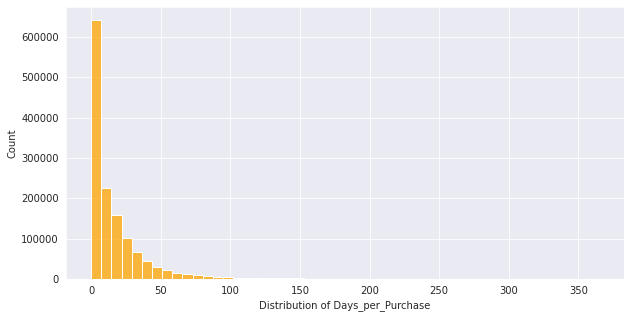

In [ ]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=transactions_byid2, x='Days_per_Purchase', bins=50, color='orange')
ax.set_xlabel('Distribution of Days_per_Purchase')
plt.show()

In [ ]:
print(transactions_byid2['Days_per_Purchase'].median(),transactions_byid2['Days_per_Purchase'].min(),transactions_byid2['Days_per_Purchase'].max())

8.478260869565217 0.0 364.5


### How many purchases for each item? Median 65

In [ ]:
transactions_byprod_n = transactions.groupby('article_id').count()
transactions_byprod_n.customer_id.median()

65.0

## 2. Filter transactions

In [97]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [98]:
# outputs
fout_transactions_filtered = '/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/transactions_filtered.csv'


### 【Filter 1】Customer: bought 2-8 items -> 474049

In [103]:
transactions_byid_n = transactions.groupby('customer_id').count()

In [104]:
# uids_include0 = np.asarray(transactions_byid_n.query('article_id >50').index)
uids_include0 = np.asarray(transactions_byid_n.query('article_id <8 and article_id>1').index)
len(uids_include0)

474049

### 【Filter 2】Item: more than 50 purchases -> 56696

In [105]:
transactions_byprod_n = transactions.groupby('article_id').count()

In [106]:
iids_include0 = np.asarray(transactions_byprod_n.query('customer_id >50').index)
len(iids_include0)

56696

### 【Filter 3】 Finalize: non-zero-sum transaction matrix

In [107]:
transactions_filtered = transactions[transactions.customer_id.isin(uids_include0) & transactions.article_id.isin(iids_include0)]
len(transactions_filtered)

1814570

In [108]:
len(transactions_filtered.customer_id.unique())

471963

In [109]:
len(transactions_filtered.article_id.unique())

55717

In [110]:
transactions_filtered.to_csv(fout_transactions_filtered, index=False)

## 3. Preprocess

In [156]:
import numpy as np
import pandas as pd
import pickle
from scipy.spatial.distance import euclidean, pdist, squareform
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [157]:
# outputs
fout_uid_dict = '/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/uid_dict_filtered.csv'
fout_iid_dict = '/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/iid_dict_filtered.csv'

fout_uu_df = '/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/uu_df.csv'

fout_gnn_train = '/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/gnn_train.csv'
fout_gnn_valid = '/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/gnn_valid.csv'
fout_gnn_test = '/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/gnn_test.csv'
fout_unique_counts = '/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/unique_counts.csv'

In [158]:
mydir = "./hm_data"
mydir_g = "/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn"

articles = pd.read_csv(mydir+"/articles.csv")
customers = pd.read_csv(mydir+"/customers.csv")
transactions = pd.read_csv(mydir_g+"/transactions_filtered.csv")

### Create dictionary

In [159]:
# create dictionary to transform customer/product id to number ids
uids = pd.Categorical(transactions['customer_id']).codes
iids = pd.Categorical(transactions['article_id']).codes

In [115]:
#uid_dict = dict(zip(transactions['customer_id'],uids)) 
#iid_dict = dict(zip(transactions['article_id'],iids)) 
uid_dict = pd.DataFrame({'customer_id': transactions.customer_id,
                        'uid': uids})
iid_dict = pd.DataFrame({'article_id': transactions.article_id,
                        'iid': iids})
uid_dict.to_csv(fout_uid_dict, index=False)
iid_dict.to_csv(fout_iid_dict, index=False)

### 【need to find better way】Get user-user similarity from user features

In [116]:
# include only customers in the filtered transaction dataset
iids_include = transactions.customer_id.unique()
customers_filtered = customers[customers.customer_id.isin(iids_include)].copy()

In [117]:
# change non-one values in FN to 0
isone_fn = customers_filtered['FN'].eq(1)
customers_filtered['FN_comp']= np.where(isone_fn, 1.0, 0)

In [118]:
# change non-one values in Active to 0
isone_act = customers_filtered['Active'].eq(1)
customers_filtered['Active_comp']= np.where(isone_act, 1.0, 0)

In [119]:
# further filters on customer features
cols_drop = ['FN','Active','club_member_status','fashion_news_frequency','postal_code']
customers_filtered.drop(cols_drop, inplace=True, axis=1)
customers_filtered = customers_filtered.reset_index(drop=True)
customers_filtered = customers_filtered.set_index('customer_id')

In [120]:
customers_filtered_norm=(customers_filtered-customers_filtered.mean())/customers_filtered.std()

In [121]:
customers_filtered_norm.head()

,age,FN_comp,Active_comp
customer_id,,,
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,1.138145,-0.648655,-0.631353
000064249685c11552da43ef22a5030f35a147f723d5b02ddd9fd22452b1f5a6,NaN,-0.648655,-0.631353
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,-1.130430,-0.648655,-0.631353
00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77334eaec4ffccd7ebcc,-1.130430,-0.648655,-0.631353
00008469a21b50b3d147c97135e25b4201a8c58997f78782a0cc706645e14493,-1.130430,-0.648655,-0.631353


In [123]:
import itertools
from scipy.stats.stats import pearsonr
from tqdm.notebook import tqdm

uu_uid = []
uu_fid = []
count = 0
my_list = customers_filtered_norm.index
for (a,b) in tqdm(itertools.combinations(my_list,2)):
  count = count +1
  try:
    mysim = pearsonr(customers_filtered_norm.loc[a, :], customers_filtered_norm.loc[b, :])
  except ValueError:
    continue
  if mysim[1] < 5e-5:
    uu_uid.append(a)
    uu_uid.append(b)
    uu_fid.append(b)
    uu_fid.append(a)
  if count >300000:
    break


0it [00:00, ?it/s]

In [124]:

uu_df = pd.DataFrame({'uid': uu_uid,
                      'fid': uu_fid})

In [125]:
uu_df.shape

(7104, 2)

In [126]:
uu_df.head()

,uid,fid
0,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,00051dc66eecbfd664831115062ef7d9798bed36b80c7c...
1,00051dc66eecbfd664831115062ef7d9798bed36b80c7c...,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0020bc07b12389473dc3d68ea9f79ad007ee56c24b67ce...
3,0020bc07b12389473dc3d68ea9f79ad007ee56c24b67ce...,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,002d2d9c17a41f5e63de988be891d1f1749f0ba82d502f...


In [127]:
uu_df.to_csv(fout_uu_df, index=False)

### Split train, valid, test set

In [128]:
# use numerically coded uids, iids
transactions2 = pd.DataFrame({'uid': uids,
                             'iid': iids,
                            'label': transactions.sales_channel_id})

In [129]:
n_unique = transactions2.nunique(axis=0)
  
print("No.of.unique values in each column :\n",
      n_unique)
n_unique_df = pd.DataFrame({'user_count': [n_unique[0]],
                            'item_count': [n_unique[1]],
                            'purchase_count': [n_unique[2]]})
n_unique_df.to_csv(fout_unique_counts, index=False)

No.of.unique values in each column :
 uid      471963
iid       55717
label         2
dtype: int64


In [130]:
del transactions
del uids
del iids

In [131]:
seed = 123
# downsample total filtered transaction to 10%, 
transactions2_sub, _ = train_test_split(transactions2, test_size=0.9, random_state=seed)
# split the downsampled data as 80%, 10&, 10& for train, valid, test
train, test_pre = train_test_split(transactions2_sub, test_size=0.2, random_state=seed)
valid, test = train_test_split(test_pre, test_size=0.5, random_state=seed)

In [132]:
print(train.shape, valid.shape, test.shape)
print('Train samples: {}, Valid samples: {}, Test samples: {}'.format(train.shape[0], valid.shape[0], test.shape[0]))

(145165, 3) (18146, 3) (18146, 3)
Train samples: 145165, Valid samples: 18146, Test samples: 18146


In [133]:
train.to_csv(fout_gnn_train, index=False)
valid.to_csv(fout_gnn_valid, index=False)
test.to_csv(fout_gnn_test, index=False)

In [134]:
del train
del valid
del test

In [135]:
import gc
gc.collect()

724

### Load train set, get graph objects

In [136]:
import os
from tqdm.notebook import tqdm

mydir_g = "/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn"

f_gnn_train = mydir_g+'/gnn_train.csv'
f_unique_counts = mydir_g+'/unique_counts.csv'

# outputs
fout_u_items_list = mydir_g+'/u_items_list.pkl'
fout_i_users_list = mydir_g+'/i_users_list.pkl'
fout_u_users_list = mydir_g+'/u_users_list.pkl'
fout_u_users_items_list = mydir_g+'/u_users_items_list.pkl'

In [137]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def append_object(obj, filename):
    with open(filename, 'ab') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [138]:
if os.path.getsize(f_gnn_train) > 0:      
  train_df = pd.read_csv(f_gnn_train)
else:
  print("File not exist")

if os.path.getsize(f_unique_counts) > 0:      
  counts_df = pd.read_csv(f_unique_counts)
else:
  print("File not exist")

In [139]:
train_df.head()

,uid,iid,label
0,459017,43635,2
1,390337,16302,2
2,384981,19376,1
3,175318,40196,2
4,91089,5277,1


In [140]:
counts_df

,user_count,item_count,purchase_count
0,471963,55717,2


#### u_items_list

In [161]:
u_items_list[0]


[(28738, 2), (39276, 2)]

In [142]:
u_items_list = []
# for user in tqdm(range(int(counts_df.user_count) + 1)):
for user in tqdm(set(train_df.uid)):
    user_df = train_df[train_df['uid'] == user]
    user_items = user_df['iid'].tolist()
    user_purchases = user_df['label'].tolist()
    if len(user_items) == 0:
        u_items_list.append([(0, 0)])
    else:
        u_items_list.append([(iid, purchase) for iid, purchase in zip(user_items, user_purchases)])

  0%|          | 0/126126 [00:00<?, ?it/s]

In [143]:
save_object(u_items_list, fout_u_items_list)

In [144]:
# load object
with open(fout_u_items_list, "rb") as f:
 u_items_list = pickle.load(f)

#### i_users_list

In [162]:
i_users_list = []
for item in tqdm(set(train_df.iid)):
    item_df = train_df[train_df['iid'] == item]
    item_users = item_df['uid'].tolist()
    item_purchases = item_df['label'].tolist()
    if len(item_users) == 0:
        i_users_list.append([(0, 0)])
    else:
        i_users_list.append([(uid, purchase) for uid, purchase in zip(item_users, item_purchases)])

  0%|          | 0/36222 [00:00<?, ?it/s]

In [163]:
save_object(i_users_list, fout_i_users_list)
print(fout_i_users_list)

/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/i_users_list.pkl


In [164]:
# load object
with open(fout_i_users_list, "rb") as f:
  i_users_list = pickle.load(f)

In [166]:
len(i_users_list)

36222

#### u_users_x

In [167]:
u_users_list = []
u_users_items_list = []
for user in tqdm(set(train_df.uid)):
    user_df = uu_df[uu_df['uid'] == user]
    u_users = user_df['fid'].unique().tolist()
    if len(u_users) == 0:
        u_users_list.append([0])
        u_users_items_list.append([[(0, 0)]])
    else:
        u_users_list.append(u_users)
        uu_items = []
        for uid in u_users:
            uu_items.append(u_items_list[uid])
        u_users_items_list.append(uu_items)

  0%|          | 0/126126 [00:00<?, ?it/s]

In [168]:
save_object(u_users_list, fout_u_users_list)
print(fout_u_users_list)

save_object(u_users_items_list, fout_u_users_items_list)
print(fout_u_users_items_list)

/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/u_users_list.pkl
/content/gdrive/MyDrive/DS4A_Capstone_local/cleaned_data_for_gnn/u_users_items_list.pkl
